# Fear Conditioning, Extinction, and Renewal in the Amygdala

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=1, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
#         self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.CTXs = [[0,1], [1,0]]
#         self.USs = self.rng.randint(2, size=nCS)
        self.USs = np.array([1,0])
        self.experiment = None
    def get_CS(self, t):
        if self.experiment == "baseline":
            idx = int(t) % self.nCS
            return self.CSs[idx]
        elif self.experiment == "conditioning":
            idx = int(t/3) % self.nCS
            applied = True if t%3>1 else False  # 1s of no input, 2s of CS input
            return self.CSs[idx] if applied else np.zeros((self.dim_CS))
        elif self.experiment == "expression":
            idx = int(t/2) % self.nCS
            applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
            return self.CSs[idx] if applied else np.zeros((self.dim_CS))
        elif self.experiment == "extinction":
            idx = int(t/2) % self.nCS
            applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
            return self.CSs[idx] if applied else np.zeros((self.dim_CS))
        else:
            return np.zeros((self.dim_CS))
    def get_CTX(self, t):
        if self.experiment in ["baseline", "conditioning", "expression"]:
            return self.CTXs[0]
        elif self.experiment == "extinction":
            idx = int(t) % self.nCS
            return self.CTXs[1]
    def get_US(self, t):
        if self.experiment in ["baseline", "expression"]:
            return 0
        elif self.experiment=="conditioning":
            idx = int(t/3) % self.nCS
            applied = True if t%3>2 else False # 2s of no input, 1s of US input 
            return self.USs[idx] if applied else 0
#             return 1 if applied else 0
        else:
            return 0
    def shuffle_CS_US(self):
        indices = np.arange(self.nCS)
        self.rng.shuffle(indices)
        self.CSs = self.CSs[indices]
        self.USs = self.USs[indices]

In [32]:
seed = 0
stimulus_seed = 0
dim_CS = 1
dim_CTX = 2
nCS = 1
nPairings = 5
nNeurons = 300
tau = 0.01

net = nengo.Network(seed=seed)
inputs = Inputs(nCS=nCS, dim_CS=dim_CS, dim_CTX=dim_CTX, seed=stimulus_seed)
intercept = (np.dot(inputs.CSs, inputs.CSs.T) - np.eye(nCS)).flatten().max()

with net:
    # inputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    # ensembles
    external_CS = nengo.Ensemble(nNeurons, dim_CS,
        intercepts=nengo.dists.Uniform(0.01, 1), encoders=nengo.dists.Choice([[1]]))
    LA_CS = nengo.Ensemble(nNeurons, dim_CS)
    LA_US = nengo.Ensemble(nNeurons, 1)
    LA_error = nengo.Ensemble(nNeurons, 1,
        intercepts=nengo.dists.Uniform(0.01, 1), encoders=nengo.dists.Choice([[1]]))
    # connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, LA_US, synapse=None)
    cConditioning = nengo.Connection(external_CS, LA_CS, synapse=tau,
        function=lambda x: 0, learning_rule_type=nengo.PES(3e-5))
    nengo.Connection(LA_CS, LA_error, transform=-1, synapse=tau)
    nengo.Connection(LA_US, LA_error, transform=+1, synapse=tau)
    nengo.Connection(LA_error, cConditioning.learning_rule, transform=-1, synapse=tau)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pLA_CS_spikes = nengo.Probe(LA_CS.neurons, synapse=tau)
    pLA_CS = nengo.Probe(LA_CS, synapse=tau)
    pLA_US = nengo.Probe(LA_US, synapse=tau)
    pLA_error = nengo.Probe(LA_error, synapse=tau)

### Experiment 1: LA activity and LA freezing

In [33]:
dt = 0.001
t_baseline = nCS
t_conditioning = 3*nCS
t_expression = 2*nCS

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    inputs.experiment = "baseline"
    print(inputs.experiment)
    sim.run(t_baseline)
    inputs.experiment = "conditioning"
    print(inputs.experiment)
    for p in range(nPairings):
        inputs.shuffle_CS_US()
        sim.run(t_conditioning)
    inputs.experiment = "expression"
    print(inputs.experiment)
    inputs.shuffle_CS_US()
    sim.run(t_expression)

baseline
conditioning
expression


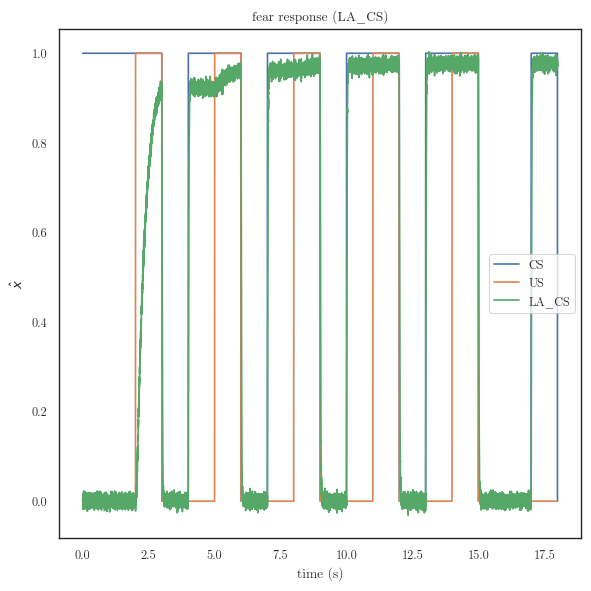

In [34]:
fig, ax = plt.subplots(figsize=((6,6)))
ax.plot(sim.trange(), sim.data[pCS], label="CS")
ax.plot(sim.trange(), sim.data[pUS], label="US")
ax.plot(sim.trange(), sim.data[pLA_CS], label="LA_CS")
# ax.plot(sim.trange(), sim.data[pLA_US], label="LA_US")
ax.legend()
ax.set(xlabel="time (s)", ylabel=r"$\hat{x}$", title="Conditioning Training")
plt.tight_layout()

In [35]:
T_baseline = int(t_baseline/dt)
T_expression = int(t_expression/dt)

dAs_control = []
dAs_baseline = []
for n in range(nCS):
    CSns_baseline = np.array([inputs.CSs[n]]*T_baseline)
    CSns_expression = np.array([inputs.CSs[n]]*T_expression)
    zeros_expression = np.array([np.zeros((dim_CS))]*T_expression)
    
    idx_CSn_baseline = np.where(CSns_baseline==sim.data[pCS][:T_baseline])[0]
    idx_CSn_expression = np.where(CSns_expression==sim.data[pCS][-T_expression:])[0]
    idx_CSn_control = np.where(zeros_expression==sim.data[pCS][-T_expression:])[0]
    
    A_CSn_baseline = sim.data[pLA_CS_spikes][:T_baseline][idx_CSn_baseline]
    A_CSn_expression = sim.data[pLA_CS_spikes][-T_expression:][idx_CSn_expression]
    A_CSn_control = sim.data[pLA_CS_spikes][-T_expression:][idx_CSn_control]
    
    dAs_baseline.append(np.mean(A_CSn_expression, axis=0) - np.mean(A_CSn_baseline, axis=0))
    dAs_control.append(np.mean(A_CSn_expression, axis=0) - np.mean(A_CSn_control, axis=0))

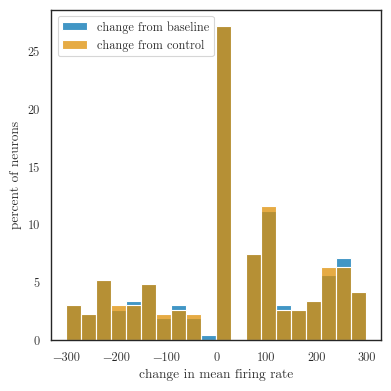

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=((4,4)))
sns.histplot(dAs_baseline[0], ax=axes, bins=20, binrange=[-300,300], stat='percent', label='change from baseline', color=palette[0])
sns.histplot(dAs_control[0], ax=axes, bins=20, binrange=[-300,300], stat='percent', label='change from control', color=palette[1])
axes.set(xlabel='change in mean firing rate', ylabel='percent of neurons')
axes.legend()
plt.tight_layout()

# fig, axes = plt.subplots(nrows=1, ncols=nCS, figsize=((3*nCS,3)), sharey=True)
# for n in range(nCS):
#     sns.histplot(dAs_baseline[n], ax=axes[n], bins=20, binrange=[-300,300], stat='percent', label='change from baseline', color=palette[0])
#     sns.histplot(dAs_control[n], ax=axes[n], bins=20, binrange=[-300,300], stat='percent', label='change from control', color=palette[1])
#     axes[n].set(title=f'CS {n}')
# axes[0].legend()
# axes[int(nCS/2)].set(xlabel='change in mean firing rate', ylabel='percent of neurons')
# plt.tight_layout()

### Experiment 2: BLA activity and BLA extinction

In [67]:
# with net:
#     # inputs
#     CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2)
#     # ensembles
#     external_CTX = nengo.Ensemble(nNeurons, dim_CTX,
#         intercepts=nengo.dists.Uniform(0.01, 1), encoders=nengo.dists.Choice([[1]]))
#     BLA = nengo.Ensemble(3*nNeurons, 4)  # [CTX, CS, US]
#     BLA_error_pos = nengo.Ensemble(nNeurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0.01, 1))
#     BLA_error_neg = nengo.Ensemble(nNeurons, 1, encoders=nengo.dists.Choice([[1]]), intercepts=nengo.dists.Uniform(0.01, 1))
#     # connections
#     nengo.Connection(CTX, external_CTX, synapse=None)
#     cExtinction = nengo.Connection(external_CTX, BLA[:2],
#        function=lambda x: [0,0], learning_rule_type=nengo.PES(3e-5), synapse=tau)
#     nengo.Connection(LA_CS, BLA[3], synapse=tau)
#     nengo.Connection(LA_US, BLA[-1], synapse=tau)
#     nengo.Connection(BLA, BLA_error_pos, function=lambda x: x[-1]-x[3], synapse=tau)  # US-CS
#     nengo.Connection(BLA, BLA_error_neg, function=lambda x: x[3]-x[-1], synapse=tau)  # CS-US
#     nengo.Connection(BLA_error_pos, cExtinction.learning_rule, transform=-1, synapse=tau)
#     nengo.Connection(BLA_error_neg, cExtinction.learning_rule, transform=+1, synapse=tau)

In [61]:
with net:
    # inputs
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2)
    # ensembles
    BLA_fear = nengo.Ensemble(nNeurons, dim_CS)
    BLA_extinct = nengo.Ensemble(nNeurons, 1)
    BLA_safe = nengo.Ensemble(3*nNeurons, dim_CS+dim_CTX+1)  # [CS, CTX, US]
    BLA_error_safe = nengo.Ensemble(nNeurons, 1,
        intercepts=nengo.dists.Uniform(0.01, 1), encoders=nengo.dists.Choice([[1]]))
    BLA_error_unsafe = nengo.Ensemble(nNeurons, 1,
        intercepts=nengo.dists.Uniform(0.01, 1), encoders=nengo.dists.Choice([[1]]))

    # connections
    nengo.Connection(LA_CS, BLA_safe[:dim_CS], synapse=tau)
    nengo.Connection(CTX, BLA_safe[dim_CS: dim_CS+dim_CTX], synapse=None)
    nengo.Connection(LA_US, BLA_safe[-1], synapse=tau)
    nengo.Connection(LA_CS, BLA_fear, synapse=tau)
    nengo.Connection(BLA_extinct, BLA_fear, transform=-1, synapse=tau)

    cContextSafe = nengo.Connection(BLA_safe, BLA_extinct, synapse=tau,
        function=lambda x: 0, learning_rule_type=nengo.PES(2e-5))
    nengo.Connection(BLA_safe, BLA_error_safe, function=lambda x: x[:dim_CS]-x[-1], synapse=tau)  # CS-US, rectified
    nengo.Connection(BLA_extinct, BLA_error_safe, transform=-1, synapse=tau)
    nengo.Connection(BLA_error_safe, cContextSafe.learning_rule, transform=-1, synapse=tau)

    cContextUnsafe = nengo.Connection(BLA_safe, BLA_extinct, synapse=tau,
        function=lambda x: 0, learning_rule_type=nengo.PES(3e-5))
    nengo.Connection(BLA_safe, BLA_error_unsafe, function=lambda x: -x[:dim_CS]*x[-1], synapse=tau)  # -CS*US, rectified
    nengo.Connection(BLA_extinct, BLA_error_unsafe, transform=+1, synapse=tau)
    nengo.Connection(BLA_error_unsafe, cContextUnsafe.learning_rule, transform=1, synapse=tau)
    
    # probes
    pCTX = nengo.Probe(CTX, synapse=None)
    pBLA_fear_spikes = nengo.Probe(BLA_fear.neurons, synapse=tau)
    pBLA_extinct_spikes = nengo.Probe(BLA_fear.neurons, synapse=tau)
    pBLA_safe_spikes = nengo.Probe(BLA_fear.neurons, synapse=tau)
    pBLA_fear = nengo.Probe(BLA_fear, synapse=tau)
    pBLA_extinct = nengo.Probe(BLA_extinct, synapse=tau)
    pBLA_safe = nengo.Probe(BLA_safe, synapse=tau)
    pBLA_error_safe = nengo.Probe(BLA_error_safe, synapse=tau)
    pBLA_error_unsafe = nengo.Probe(BLA_error_unsafe, synapse=tau)

In [62]:
dt = 0.001
t_baseline = nCS
t_conditioning = 3*nCS
t_expression = 2*nCS
t_extinction = 2*nCS

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    inputs.experiment = "baseline"
    print(inputs.experiment)
    sim.run(t_baseline)
    inputs.experiment = "conditioning"
    print(inputs.experiment)
    for p in range(nPairings):
        inputs.shuffle_CS_US()
        sim.run(t_conditioning)
    inputs.experiment = "expression"
    print(inputs.experiment)
    inputs.shuffle_CS_US()
    sim.run(t_expression)
    inputs.experiment = "extinction"
    print(inputs.experiment)
    for p in range(nPairings):
        inputs.shuffle_CS_US()
        sim.run(t_extinction)

baseline
conditioning
expression
extinction


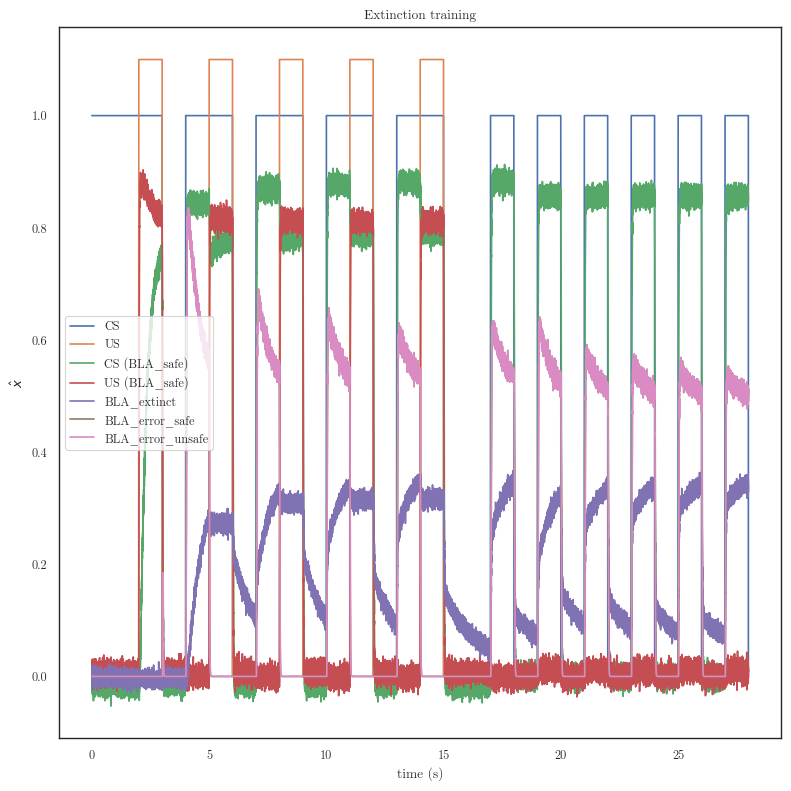

In [63]:
fig, ax = plt.subplots(figsize=((8,8)))
ax.plot(sim.trange(), sim.data[pCS], label="CS")
ax.plot(sim.trange(), 1.1*sim.data[pUS], label="US")
# ax.plot(sim.trange(), 0.5*sim.data[pCTX], label="CTX")
# ax.plot(sim.trange(), sim.data[pLA_CS], label="LA_CS")
# ax.plot(sim.trange(), sim.data[pBLA_fear], label="BLA_fear")
ax.plot(sim.trange(), sim.data[pBLA_safe][:,0], label="CS (BLA_safe)")
ax.plot(sim.trange(), sim.data[pBLA_safe][:,-1], label="US (BLA_safe)")
ax.plot(sim.trange(), sim.data[pBLA_extinct], label="BLA_extinct")
ax.plot(sim.trange(), sim.data[pBLA_error_safe], label="BLA_error_safe")
ax.plot(sim.trange(), sim.data[pBLA_error_safe], label="BLA_error_unsafe")
ax.legend()
ax.set(xlabel="time (s)", ylabel=r"$\hat{x}$", title="Extinction training")
plt.tight_layout()